In [40]:
import time
from itertools import product

import pandas as pd
from pandas.tseries.frequencies import to_offset
import numpy as np
import vectorbtpro as vbt
import warnings
warnings.filterwarnings("ignore")

In [41]:
# This is the number of days we'll look back to 
# calculate the rolling z-score.
window = 22

# This is the number of standard deviations the 
# z-score needs to be above or below to trigger
# a trading signal.
thresh = 2
upper_threshold = 1.8
lower_threshold = -2

# Set the end date to today.
end = pd.Timestamp.today().strftime("%Y-%m-%d")

In [134]:
long_entry = -2
long_exit = 2
short_entry = 1.8
short_exit = 0

In [135]:
# Paramaterize the refiner symbol to easily swap
# them out.
refiner_symbol = "VLO"

In [136]:
# Use the VectorBT data download functionality to
# grab price history data.
data = vbt.YFData.pull(
    [
        "CL=F", 
        "RB=F", 
        "HO=F", 
        refiner_symbol
    ], 
    start="2020", 
    end=end,
    missing_index="drop"
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [137]:
# The data object requires us to extract the data.
cl = data.get("Close")["CL=F"]
rb = data.get("Close")["RB=F"]
ho = data.get("Close")["HO=F"]
refiner = data.get("Close")[refiner_symbol]

In [138]:
type(data)

vectorbtpro.data.custom.yf.YFData

In [139]:
# Construct the crack spread which is defined as
# long one heating oil contract, long two gasoline
# contracts, and short three crude oil contracts.
crack_spread = ho + 2 * rb - 3 * cl

In [140]:
crack_spread

Date
2020-01-02 00:00:00-05:00   -178.107501
2020-01-03 00:00:00-05:00   -183.590998
2020-01-06 00:00:00-05:00   -184.267301
2020-01-07 00:00:00-05:00   -182.623202
2020-01-08 00:00:00-05:00   -173.574202
                                ...    
2024-02-28 00:00:00-05:00   -228.419703
2024-02-29 00:00:00-05:00   -227.487606
2024-03-01 00:00:00-05:00   -231.977004
2024-03-04 00:00:00-05:00   -228.401393
2024-03-05 00:00:00-05:00   -226.633995
Length: 1050, dtype: float64

In [141]:
type(data)

vectorbtpro.data.custom.yf.YFData

In [142]:
type(data.data)

vectorbtpro.data.base.symbol_dict

In [143]:
vbt.Data.from_data(vbt.merge_dicts(data.data, data.data))

In [144]:
# crack_spread.plot(label='Crack Spread')
# refiner.plot(label='Refiner')
# plt.legend()
# plt.show()


<Axes: xlabel='Date'>

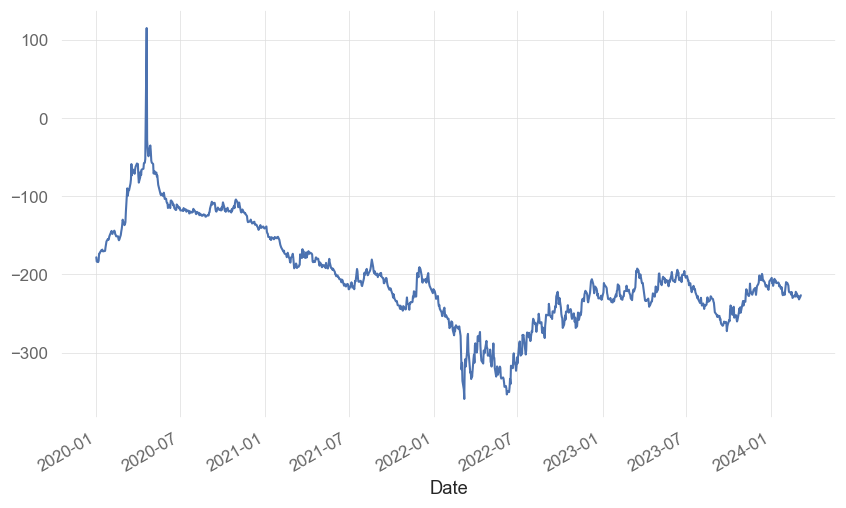

In [145]:
# Plot it.
crack_spread.plot()

In [146]:
# Now use the percentile rank to normalize the spread so we can
# compare it to the refiner stock
crack_spread_rank = crack_spread.rolling(window).rank(pct=True)

<Axes: xlabel='Date'>

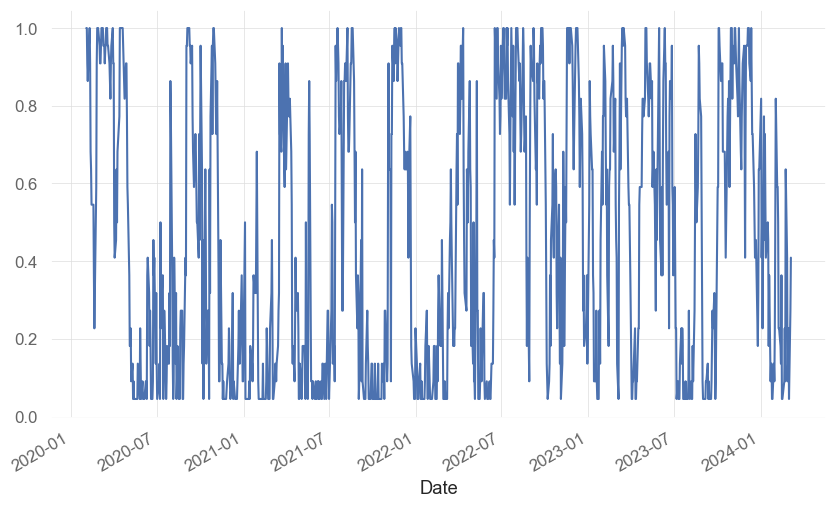

In [147]:
# Plot it.
crack_spread_rank.plot()

In [148]:
# Compute the percentile rank for the refiner's price
refiner_rank = refiner.rolling(window).rank(pct=True)

<Axes: xlabel='Date'>

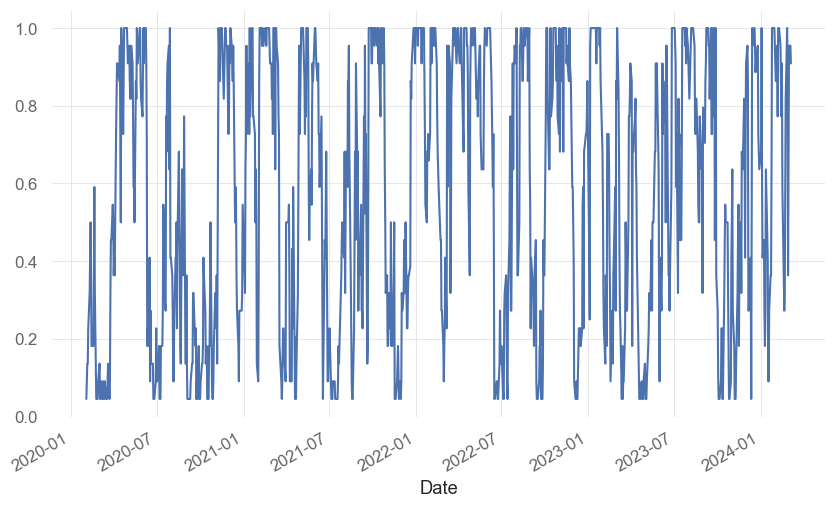

In [149]:
# Plot it.
refiner_rank.plot()

In [150]:
# Now compare the difference between the price performance by
# subtracting the rank
rank_spread = refiner_rank - crack_spread_rank

<Axes: xlabel='Date'>

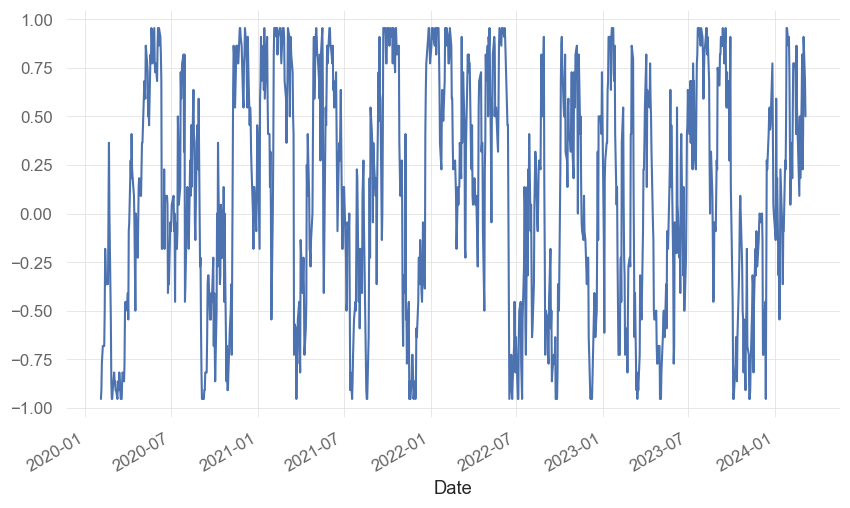

In [151]:
# Plot it.
rank_spread.plot()

In [152]:
# Normalize the difference by taking the z-score which forms our
# trading signal.
roll = rank_spread.rolling(window)
zscore = ((rank_spread - roll.mean()) / roll.std())

<Axes: xlabel='Date'>

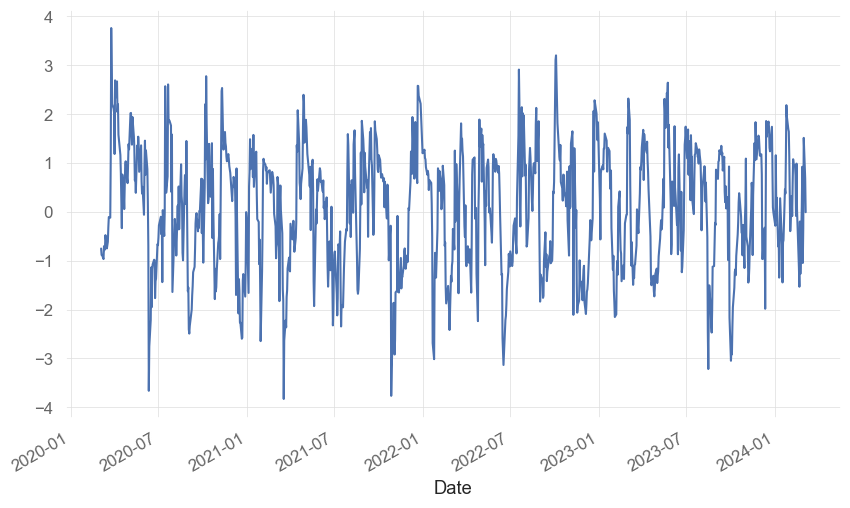

In [153]:
# Plot it.
zscore.plot()

In [154]:
# Find all occurences where the z-score crosses below the lower
# threshold and get long. Then set an exit when the z-score crosses
# above -1. Filter out all entry signals if the position has already 
# been entered, and exit signals if the position has already been exited.
long_entries = zscore.vbt.crossed_below(long_entry)  # long entries
long_exits = zscore.vbt.crossed_above(long_exit)
clean_long_entries, clean_long_exits = long_entries.vbt.signals.clean(long_exits)

In [155]:
# Visualize long entries and exists
fig = zscore.vbt.plot()
clean_long_entries.vbt.signals.plot_as_entries(zscore, fig=fig)
clean_long_exits.vbt.signals.plot_as_exits(zscore, fig=fig)
fig.add_hline(y=long_exit, line_color="orangered", line_dash="dot")
fig.add_hline(y=0, line_color="yellow", line_dash="dot")
fig.add_hline(y=long_entry, line_color="limegreen", line_dash="dot")
fig.show()

In [156]:
# Find all occurences where the z-score crosses above the upper
# threshold and get short. Then set an exit when the z-score crosses
# below 1. Filter out all entry signals if the position has already 
# been entered, and exit signals if the position has already been exited.
short_entries = zscore.vbt.crossed_above(short_entry)  # short entries
short_exits = zscore.vbt.crossed_below(short_exit)
clean_short_entries, clean_short_exits = short_entries.vbt.signals.clean(short_exits)

In [157]:
# Visualize short entries and exists
fig = zscore.vbt.plot()
clean_short_entries.vbt.signals.plot_as_exits(zscore, fig=fig)
clean_short_exits.vbt.signals.plot_as_entries(zscore, fig=fig)
fig.add_hline(y=short_exit, line_color="orangered", line_dash="dot")
fig.add_hline(y=0, line_color="yellow", line_dash="dot")
fig.add_hline(y=short_entry, line_color="limegreen", line_dash="dot")
fig.show()

In [158]:
# Run a backtest based on the closing price of the refiner using the z-score of the
# spread between the percentile rank of refiner and the crack spread as the
# entry and exit signals. Trade 10 shares and start with 25K.
pf = vbt.Portfolio.from_signals(
    close=refiner,
    # entries=clean_long_entries,
    # exits=clean_long_exits,
    short_entries=clean_short_entries,  # if you want to go short
    short_exits=clean_short_exits,  # if you want to go short
    size=1.0,  # 10% invested
    size_type="percent",
    init_cash=100_000,
    freq="1D"
)

In [159]:
# Print out the summary stats from the initial backtest.
pf.stats()

Start                          2020-01-02 00:00:00-05:00
End                            2024-03-05 00:00:00-05:00
Period                                1050 days 00:00:00
Start Value                                     100000.0
Min Value                                   40777.255051
Max Value                                       100000.0
End Value                                   48884.350885
Total Return [%]                              -51.115649
Benchmark Return [%]                           83.943194
Total Time Exposure [%]                        22.666667
Max Gross Exposure [%]                        186.550822
Max Drawdown [%]                               59.222745
Max Drawdown Duration                  993 days 00:00:00
Total Orders                                          42
Total Fees Paid                                      0.0
Total Trades                                          21
Win Rate [%]                                   47.619048
Best Trade [%]                 

In [160]:
# Plot charts of orders along, trades, and cumulative returns.
pf.plot(settings=dict(bm_returns=False)).show()

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-03-26   2020-03-26
End Period                 2024-03-05   2024-03-05
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       24.0%

Cumulative Return          336.42%      -51.12%
CAGR﹪                     29.41%       -11.77%

Sharpe                     1.22         -0.58
Prob. Sharpe Ratio         98.22%       16.52%
Smart Sharpe               1.2          -0.58
Sortino                    1.99         -0.76
Smart Sortino              1.96         -0.75
Sortino/√2                 1.41         -0.54
Smart Sortino/√2           1.39         -0.53
Omega                      0.83         0.83

Max Drawdown               -51.29%      -58.48%
Longest DD Days            256          1430
Volatility (ann.)          57.56%       34.64%
R^2                        0.27         0.27
Information Ratio          -0.06        -0.06
Calmar    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-04-06,2022-05-06,2024-03-05,1430,-58.478857,-55.533701
2,2020-03-30,2020-03-30,2020-03-31,2,-6.282843,-0.935116
3,2020-04-02,2020-04-02,2020-04-02,1,-1.306833,NaN


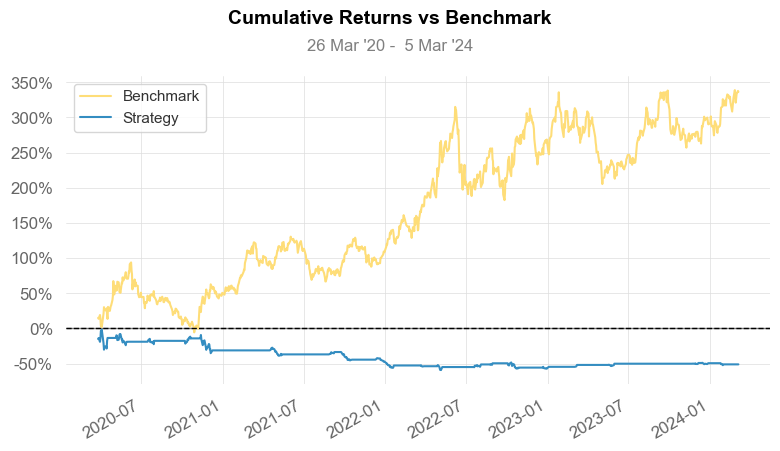

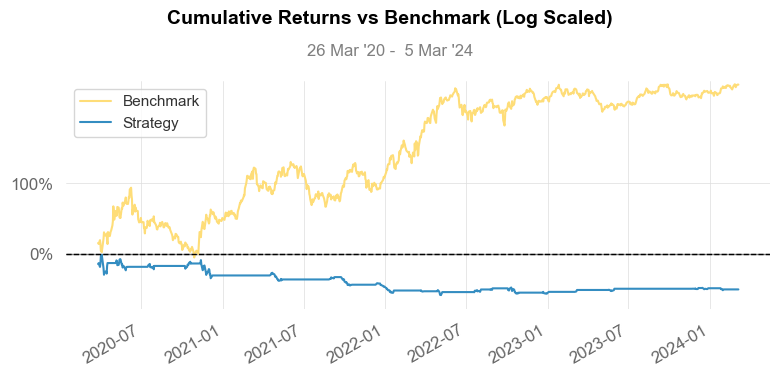

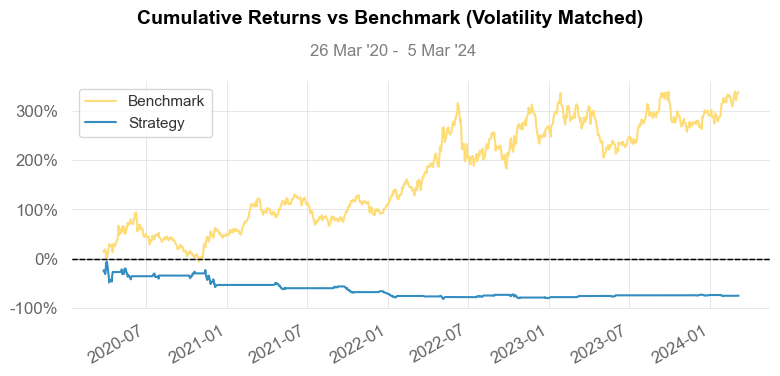

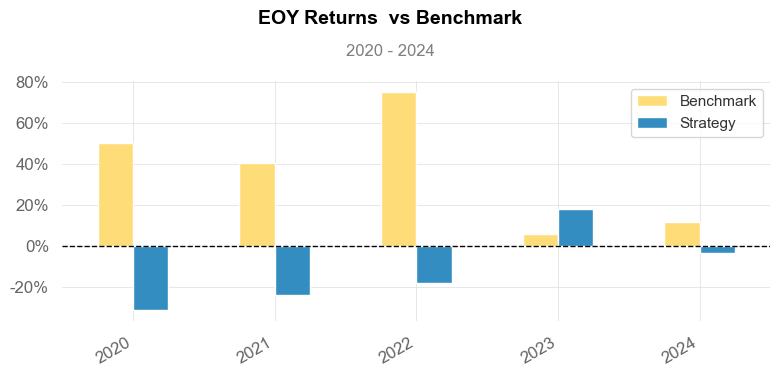

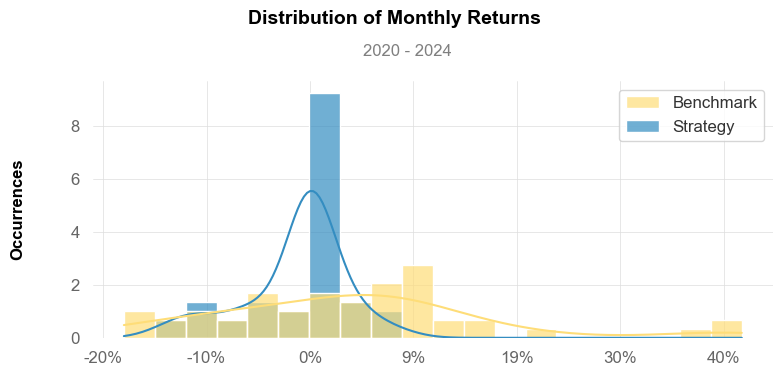

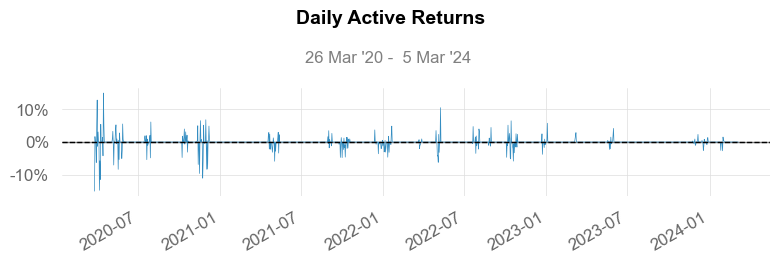

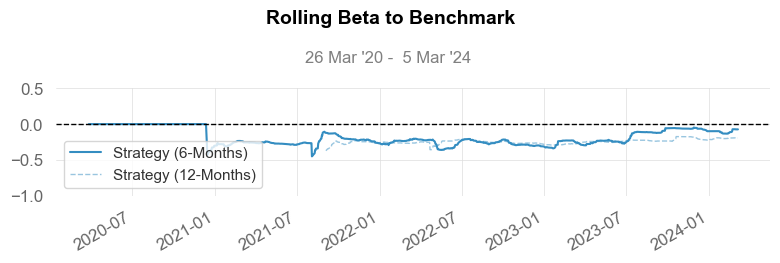

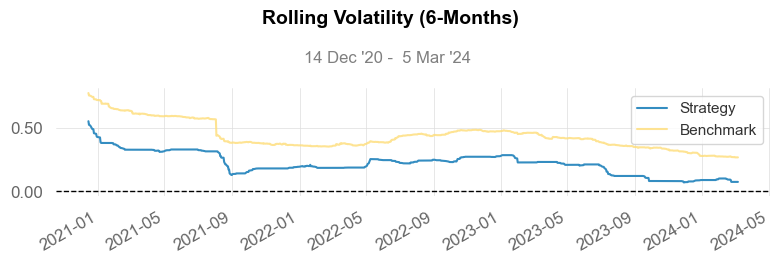

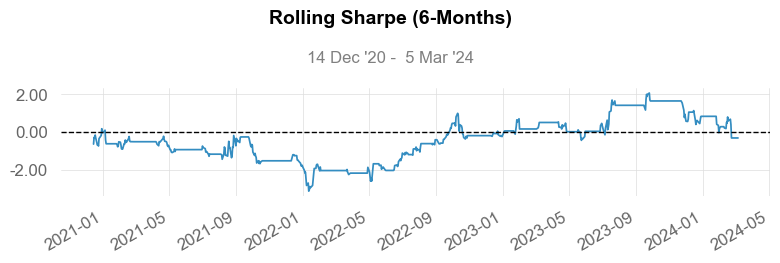

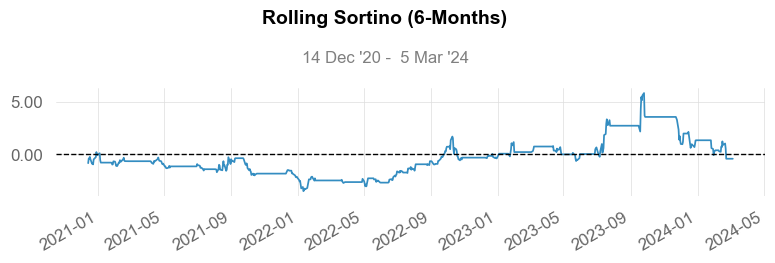

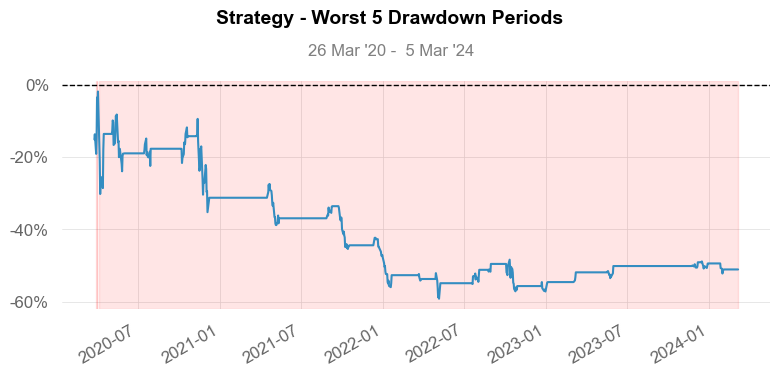

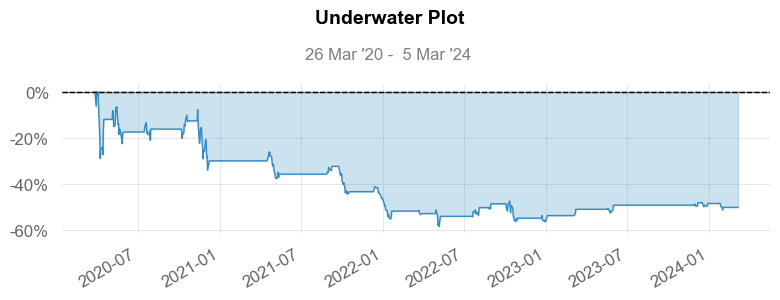

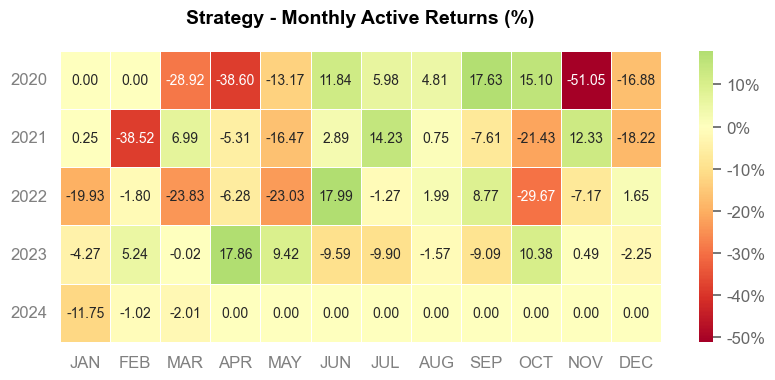

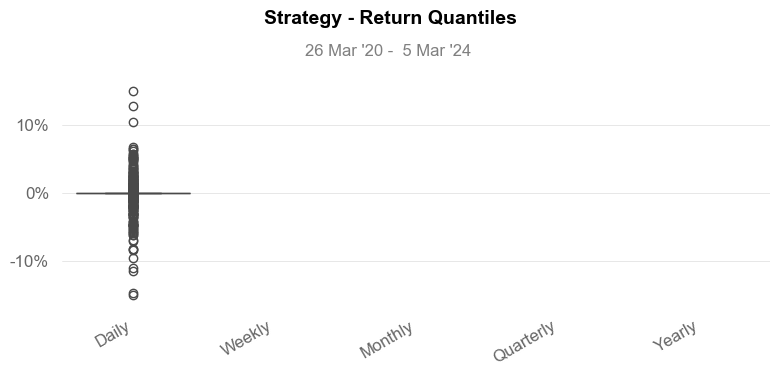

In [161]:
# Generate a Quantstats report.
pf.qs.full_report()

# Time to optimize

In [162]:
# Generate a function that accepts the parameters we want to optimize.
# In our case they are the entry and exit thresholds. The rest of the
# code is the same as before.
def test_strat(entry_th=2, exit_th=0):
    
    # Generate long entries
    long_entries = zscore.vbt.crossed_below(-entry_th)  # long entries
    long_exits = zscore.vbt.crossed_above(exit_th)
    clean_long_entries, clean_long_exits = long_entries.vbt.signals.clean(long_exits)
    
    # Generate short entries
    short_entries = zscore.vbt.crossed_above(entry_th)  # short entries
    short_exits = zscore.vbt.crossed_below(-exit_th)
    clean_short_entries, clean_short_exits = short_entries.vbt.signals.clean(short_exits)
    
    # Run the backtest
    pf = vbt.Portfolio.from_signals(
        close=refiner,
        entries=clean_long_entries,
        exits=clean_long_exits,
        # short_entries=clean_short_entries,  # if you want to go short
        # short_exits=clean_short_exits,  # if you want to go short
        size=1.0,  # Fully invested
        size_type="percent",
        init_cash=25_000,
        freq="1D"
    )

    return pf.stats([
        "total_return",
        "total_trades",
        "win_rate",
        "expectancy"
    ])
    


In [163]:
# Run the function with the defaults to return the total return,
# total trade count, win rate, and expectancy.
test_strat()

Total Return [%]    -40.900448
Total Trades                16
Win Rate [%]              50.0
Expectancy         -639.069499
dtype: object

In [164]:
# Generate a range of entry and exit threholds between 0.01 and 3.4.
entry_th = [i / 10 for i in range(1, 35)]
exit_th = [i / 10 for i in range(1, 35)]

In [165]:
# Combine the thresholds together into a list of tuples that contain
# every combination of entry and exit thresholds. There are 1156
# different combinations we'll backtest.
th_combs = list(product(entry_th, exit_th))
len(th_combs)

1156

In [166]:
# Run all the different combinations of strategies to find the optimal
# combination of entry and exit thresholds. This takes about 30 seconds.
start_time = time.time()
comb_stats = [
    test_strat(entry_th=entry_th, exit_th=exit_th)
    for entry_th, exit_th in th_combs
]
print(f"Run took ~{int(time.time() - start_time)} seconds")

Run took ~308 seconds


In [167]:
# Convert the backtest combinations from a list to a DataFrame with 
# metrics arranged as columns:
comb_stats_df = pd.DataFrame(comb_stats)
comb_stats_df

,Total Return [%],Total Trades,Win Rate [%],Expectancy
0,43.989664,68,69.117647,161.726706
1,41.464949,65,70.769231,159.480571
2,50.804715,63,69.841270,201.606012
3,52.876361,62,70.967742,213.211133
4,56.128498,60,73.333333,233.868743
...,...,...,...,...
1151,108.346384,1,100.000000,27086.596070
1152,108.346384,1,100.000000,27086.596070
1153,118.122751,1,100.000000,29530.687791
1154,180.614188,1,NaN,NaN


In [168]:
# Build a MultiIndex DataFrame with two levels, entry_th and exit_th, 
# and make it the index of comb_stats_df. This aligns each run with 
# that run's statistics.
comb_stats_df.index = pd.MultiIndex.from_tuples(
    th_combs, 
    names=['entry_th', 'exit_th']
)
comb_stats_df

Total Return [%]  Total Trades  Win Rate [%]    Expectancy
entry_th exit_th                                                            
0.1      0.1             43.989664            68     69.117647    161.726706
         0.2             41.464949            65     70.769231    159.480571
         0.3             50.804715            63     69.841270    201.606012
         0.4             52.876361            62     70.967742    213.211133
         0.5             56.128498            60     73.333333    233.868743
...                            ...           ...           ...           ...
3.4      3.0            108.346384             1    100.000000  27086.596070
         3.1            108.346384             1    100.000000  27086.596070
         3.2            118.122751             1    100.000000  29530.687791
         3.3            180.614188             1           NaN           NaN
         3.4            180.614188             1           NaN           NaN

[1156 rows x 4 columns]

In [169]:
# Plot a heatmap to see where our parameter combinations 
# perform well.
comb_stats_df['Total Return [%]'].vbt.heatmap().show()

In [170]:
# Find the paramter combination that maximizes the in sample
# return
total_returns = comb_stats_df['Total Return [%]']
max_total_return = comb_stats_df['Total Return [%]'].max()
comb_stats_df[total_returns == max_total_return]

,,Total Return [%],Total Trades,Win Rate [%],Expectancy
entry_th,exit_th,,,,
0.2,2.6,331.108589,6,60.0,10615.456208


In [171]:
# And run the strategy with these results.
test_strat(0.8, 0.1)

Total Return [%]    -29.556278
Total Trades                47
Win Rate [%]         72.340426
Expectancy         -157.214242
dtype: object